# Lab Session 1: Image Histograms and Spatial Filtering
## Introduction
Welcome to W3 Computer Vision and Imaging lab. In this session, you'll dive into fundamental image processing operations that form the backbone of many advanced computer vision tasks. We will focus on two key areas:

1. Image Histograms: Analysing and modifying the intensity distribution of an image to enhance contrast.
2. Spatial Filtering: Using small convolution kernels to smooth (low-pass) or sharpen (high-pass) an image.

## Time Allotment
This lab is designed to be completed in 50 minutes. Please focus on completing the main coding sections and observing the results.

## Expected Outcomes
Upon successful completion of this lab, you should be able to:

- Understand what an image histogram represents.
- Apply Histogram Stretching and Equalisation to improve image contrast.
- Explain the difference between low-pass (smoothing) and high-pass (sharpening) filters.
- Use basic Python libraries (numpy, skimage, scipy, matplotlib) for image manipulation.


## 0. Setup and Image Loading
Before we start, we need to import the necessary libraries and load a standard grayscale image.
### Imports
Run the following cell to import all required libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure
from scipy.ndimage import gaussian_filter, convolve

# Set up matplotlib to display images nicely
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

### Load Image
We will work with a grayscale image for simplicity. Run the following cell to load and display the image:

Image shape: (679, 800)


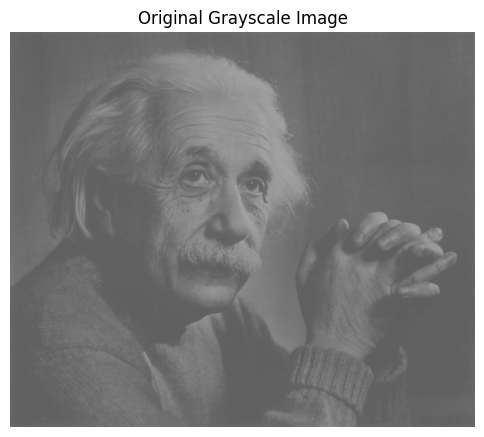

In [3]:
# NOTE: Replace 'path/to/your/image.tif' with the actual path to your image file
try:
    img = io.imread('Einstein_lowcontrast.png', as_gray=True) 
except FileNotFoundError:
    # Fallback if a specific image is not provided
    img = np.zeros((128, 128))
    img[20:108, 20:108] = np.linspace(0.1, 0.9, 88)[np.newaxis, :]
    print("Warning: Default dummy image loaded. Please use a real image for better results.")

print(f"Image shape: {img.shape}")

# Display the original image
plt.title('Original Grayscale Image')
plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

### 1.Image Histograms (15 minutes)
An image histogram shows the distribution of pixel intensities. We will use Histogram Equalization to stretch this distribution, making the overall image contrast higher.

**1.1. Original Histogram**

Task: Compute and plot the histogram of the original image.

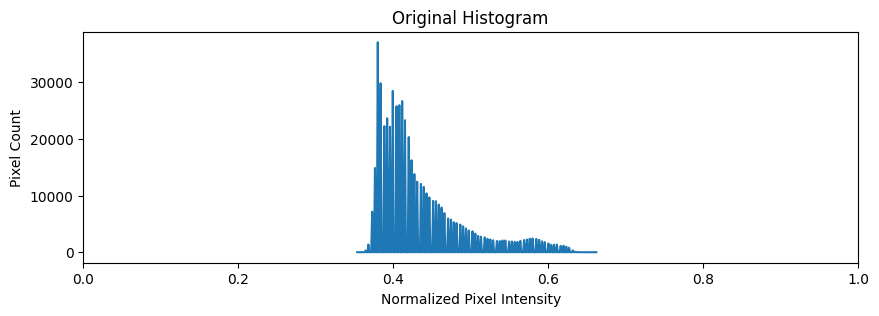

In [4]:
# Compute histogram data
hist, bins = exposure.histogram(img, nbins=256)

plt.figure(figsize=(10, 3))
plt.title('Original Histogram')
plt.plot(bins, hist)
plt.xlim([0, 1])
plt.xlabel('Normalized Pixel Intensity')
plt.ylabel('Pixel Count')
plt.show()

**1.2. Manual Histogram Stretching (Min-Max)**

Task: Implement Min-Max Histogram Stretching. Find the minimum ($i_{min}$) and maximum ($i_{max}$) intensity values in the image and apply the transformation:
 $$g(x, y) = \frac{f(x, y) - i_{\min}}{i_{\max} - i_{\min}} $$
 *NOTE: You must handle the case where $i_{\max} = i_{\min}$ to avoid division by zero.* 


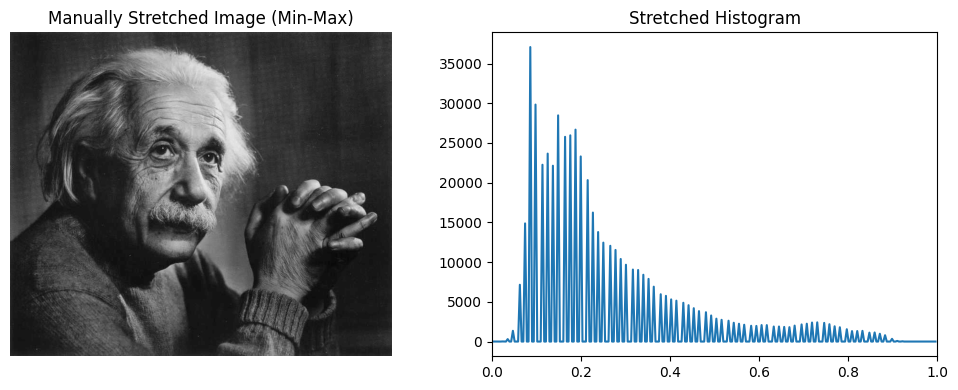

In [5]:
# Solution
# 1. Find the min and max intensities
i_min = np.min(img)
i_max = np.max(img)

# 2. Check for constant image case
if i_max == i_min:
    img_stretched = img.copy() # No change
    print("Warning: Image is constant. Stretching had no effect.")
else:
    # 3. Apply the stretching formula (element-wise)
    img_stretched = (img - i_min) / (i_max - i_min)


# Display results
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Manually Stretched Image (Min-Max)')
plt.imshow(img_stretched, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

# Compute and plot the new histogram
hist_stretched, bins_stretched = np.histogram(img_stretched.flatten(), bins=256, range=(0, 1))
bins_stretched = bins_stretched[:-1]

plt.subplot(1, 2, 2)
plt.plot(bins_stretched, hist_stretched)
plt.title('Stretched Histogram')
plt.xlim([0, 1])
plt.tight_layout()
plt.show()

**1.3. Manual Histogram Equalisation**

Example: Implement Histogram Equalisation by calculating the normalised cumulative histogram and using the discrete mapping function:


$s_k = (L-1) \sum_{j=0}^{k}p_r(r_j)$ for $k=0,1,2,\ldots, L-1$ 
Where 

- $L-1=255$ is the maximum greyscale value (e.g. 255) 
- $p_r(r_j)$ is the normalised histogram value for $r_j$
- $\sum_{j=0}^{k}p_r(r_j)$ is the normalised Cumulative Histogram (equivalent to the Cumulative Distribution Function, CDF).
-$s_k$ is the output pixel value,


The final mapped value must be converted back to the normalised range (0 to 1).

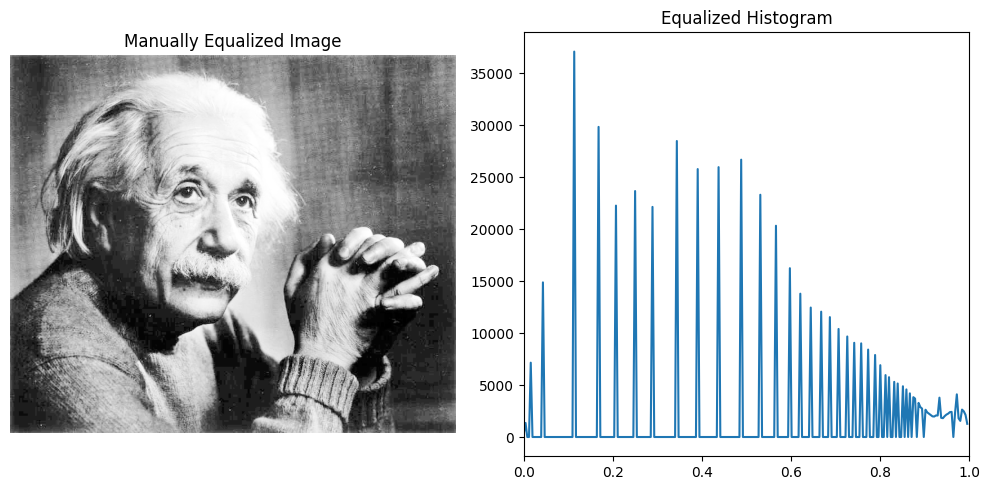

In [6]:
# Solution
# 1. Compute the histogram (h) and total number of pixels (MN)
hist_counts, _ = np.histogram(img.flatten(), bins=256, range=(0, 1))
MN = img.size

# 2. Compute the Normalized Histogram p_r(r_j)
hist_normalized = hist_counts / MN

# 3. Compute the Cumulative Sum (Normalized Cumulative Histogram)
cumulative_sum = hist_normalized.cumsum()

# 4. Create the Equalization Mapping s_k (Integer lookup table)
# s_k = (L-1) * sum(p_r) --> np.round(255 * cumulative_sum)
s_k = np.round(255 * cumulative_sum)

# 5. Apply the mapping to the image pixels
# Map float input (0-1) to integer index (0-255) for lookup
img_indices = np.round(img * 255).astype(np.int32)
# Apply lookup and convert back to normalized float (0-1)
img_equalized = s_k[img_indices] / 255.0


# --- Display Code (Do Not Modify) ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_equalized, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Manually Equalized Image')
axes[0].axis('off')

# Compute and plot the new histogram
hist_eq, bins_eq = np.histogram(img_equalized.flatten(), bins=256, range=(0, 1))
bins_eq = bins_eq[:-1]

axes[1].plot(bins_eq, hist_eq)
axes[1].set_title('Equalized Histogram')
axes[1].set_xlim([0, 1])
plt.tight_layout()
plt.show()


### 2. Pixel and Neighborhood Operations

**2.1. Single-Pixel Operation: Image Negative**

Task: Create the negative of the image using the simple single-pixel operation:$g(x,y) = 1.0 -f(x,y)$

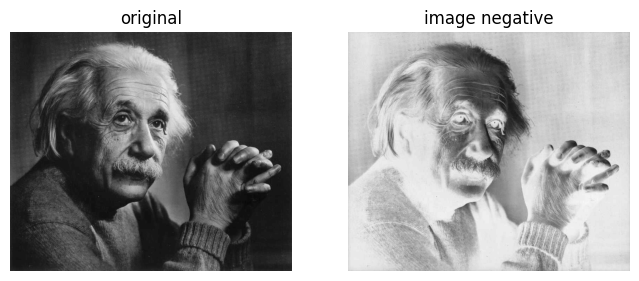

In [7]:
# -----------------
# 2.1 YOUR CODE HERE
# -----------------

img_negative = 1.0 - img_stretched 
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(img_stretched, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("image negative")
plt.imshow(img_negative, cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.show()


**2.2 Neighborhood Operation: Mean Filter (3x3)**

Task: Apply an mxm Mean Filter using the scipy.ndimage.convolve function. This is a simple low-pass (smoothing) filter.
Consider the example for: $Kernel=(1/(3*3))×ones(3,3)$.

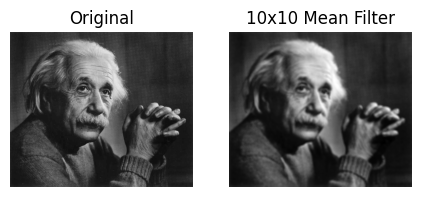

In [8]:
# Solution
# 1. Define the 3x3 Mean Kernel
mean_kernel = 1/9.0 * np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
]) 

# 2. Apply Convolution
img_mean_filtered3x3 = convolve(img, mean_kernel)



# --- Display Code (Do Not Modify) ---
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('3x3 Mean Filter')
plt.imshow(img_mean_filtered3x3, cmap='gray')
plt.axis('off')

# -----------------
# 2.2 YOUR CODE HERE
# -----------------
m = 10
mean_kernel = 1/(m*m) * np.ones((m,m))
img_mean_filteredmxn = convolve(img_stretched, mean_kernel)
plt.subplot(1,3,2) 
plt.title(f'{m}x{m} Mean Filter')
plt.imshow(img_mean_filteredmxn, cmap='gray')
plt.axis('off')
plt.show()


### 3. Filtering

**3.1. Gaussian Low-Pass Filter (Manual Kernel)**

Task: Manually create a Gaussian kernel with a standard deviation $\sigma= 1.0$ using the 2D Gaussian function:

$G(x,y) = \frac{1}{k} * \exp(- \frac{s^2 + t^2}{2*\sigma^2})$

A good rule of thumb is to use a size that covers about 4 times the sigma value (and ensuring it's an odd number).

In [9]:
# -----------------
# 2.1 YOUR CODE HERE
# -----------------
sigma = 5.0 
k_radius = int(4*sigma) 
size =